In [ ]:
# %pip install h5py seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

pd.set_option('display.max_columns', None) 

import numpy as np
import math
from math import radians, sin, cos, sqrt, atan2

import glob
from datetime import datetime
from datetime import timedelta
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [1]:
cemaden_daily_data_path = r'.\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\BRASIL_CEMADEN_TOTAL_DAILY_V3.h5'

In [3]:
def calculate_quality_label(row):
    if row['quality_index'] >= 90 and row['p_availability'] >= 99:
        return '1 - Excellent Quality'
    elif row['quality_index'] >= 85 and row['p_availability'] >= 95:
        return '2 - Good Quality'
    elif row['quality_index'] >= 80 and row['p_availability'] >= 90:
        return '3 - Acceptable Quality'
    elif row['quality_index'] >= 50:
        return '4 - Low Quality'
    else:
        return '5 - Very Low Quality'

In [4]:
def absolute_quality_label(row):
    if row['quality_label'] in ['Excellent Quality', 'Good Quality', 'Acceptable Quality']:
        return 'HQ'
    elif row['quality_label'] in ['Low Quality', 'Very Low Quality']:
        return 'LQ'
    else:
        return 'Unknown'

# Reading data

In [6]:
df_cemaden_daily = pd.read_hdf(cemaden_daily_data_path, key = 'table_data')
df_cemaden_daily['year'] = df_cemaden_daily['datetime'].dt.year
df_cemaden_daily = df_cemaden_daily[(df_cemaden_daily['rain_mm'] >= 0.0) & (df_cemaden_daily['rain_mm'] <= 600.0)]
df_cemaden_daily = df_cemaden_daily[df_cemaden_daily['year'] <= 2020]
df_cemaden_daily

,gauge_code,datetime,rain_mm,year
0,120040101A,2014-02-01,26.947336,2014
1,120040101A,2014-02-02,7.092065,2014
2,120040101A,2014-02-03,0.792680,2014
3,120040101A,2014-02-04,0.600000,2014
4,120040101A,2014-02-05,0.600000,2014
...,...,...,...,...
4300,172210701A,2020-12-27,0.200000,2020
4301,172210701A,2020-12-28,0.000000,2020
4302,172210701A,2020-12-29,27.030000,2020
4303,172210701A,2020-12-30,0.200000,2020


In [7]:
len(df_cemaden_daily['gauge_code'].unique())

4178

In [8]:
years = df_cemaden_daily['year'].sort_values(ascending=True).drop_duplicates().values.tolist()
years

[2014, 2015, 2016, 2017, 2018, 2019, 2020]

# Preclassif

In [16]:
# Add a year column to the dataframe
df_cemaden_daily['year'] = df_cemaden_daily['datetime'].dt.year

# Group by gauge_code and year
grouped = df_cemaden_daily.groupby(['gauge_code', 'year'])

# Calculate annual_rainfall_mm, active_days, and consecutive_dry_days
def calculate_metrics(group):
    annual_rainfall_mm = group['rain_mm'].sum()
    active_days = (group['rain_mm'] >= 0.0).sum()
    
    # Calculate consecutive dry days
    dry_days = (group['rain_mm'] == 0.0).astype(int)
    # Calculate the maximum number of consecutive dry days
    consecutive_dry_days = (dry_days.groupby((dry_days != dry_days.shift()).cumsum()).cumsum() * dry_days).max()
    
    return pd.Series({
        'annual_rainfall_mm': annual_rainfall_mm,
        'active_days': active_days,
        'consecutive_dry_days': consecutive_dry_days
    })

In [17]:
df_preclassif = grouped.apply(calculate_metrics).reset_index()
df_preclassif

C:\Users\linde\AppData\Local\Temp\ipykernel_25296\356056228.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_preclassif = grouped.apply(calculate_metrics).reset_index()


,gauge_code,year,annual_rainfall_mm,active_days,consecutive_dry_days
0,110018901A,2018,969.740000,136.0,21.0
1,110018901A,2019,1786.230000,365.0,58.0
2,110018901A,2020,347.270000,366.0,328.0
3,110020501A,2014,108.270409,16.0,2.0
4,110020501A,2017,138.460000,92.0,55.0
...,...,...,...,...,...
22768,CEMADEN_12,2019,598.120000,90.0,5.0
22769,CEMADEN_12,2020,398.050000,31.0,1.0
22770,CEMADEN_13,2019,51.800000,30.0,12.0
22771,CEMADEN_14,2018,436.400000,92.0,3.0


In [18]:
df_preclassif = grouped.apply(calculate_metrics).reset_index()
df_preclassif
df_preclassif['preclassif'] = df_preclassif.apply(
    lambda row: 'LQ' if (row['annual_rainfall_mm'] < 300 or row['annual_rainfall_mm'] > 6000
                        #  or row['active_days'] < 305
                         or row['consecutive_dry_days'] > 200) else "", axis=1)
df_preclassif

C:\Users\linde\AppData\Local\Temp\ipykernel_25296\4172336990.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_preclassif = grouped.apply(calculate_metrics).reset_index()


,gauge_code,year,annual_rainfall_mm,active_days,consecutive_dry_days,preclassif
0,110018901A,2018,969.740000,136.0,21.0,
1,110018901A,2019,1786.230000,365.0,58.0,
2,110018901A,2020,347.270000,366.0,328.0,LQ
3,110020501A,2014,108.270409,16.0,2.0,LQ
4,110020501A,2017,138.460000,92.0,55.0,LQ
...,...,...,...,...,...,...
22768,CEMADEN_12,2019,598.120000,90.0,5.0,
22769,CEMADEN_12,2020,398.050000,31.0,1.0,
22770,CEMADEN_13,2019,51.800000,30.0,12.0,LQ
22771,CEMADEN_14,2018,436.400000,92.0,3.0,


In [19]:
preclassif_counts = df_preclassif['preclassif'].value_counts()
print(preclassif_counts)

preclassif
      18278
LQ     4495
Name: count, dtype: int64


In [20]:
preclassif_counts['LQ'] / preclassif_counts.sum()

0.19738286567426339

In [22]:
df_preclassif.to_hdf(cemaden_daily_data_path
                     , complevel = 9
                     , key = 'preclassif'
                     , mode = 'r+'
                     , format='table'
                     , append=False
                     , index=False)

# Outlier treatment

In [25]:
df_info = pd.read_hdf(cemaden_daily_data_path, key = 'table_info')
df_info

,gauge_code,state,city,name_station,long,lat
0,110018901A,RO,PIMENTA BUENO,Apidia,-61.182871,-11.683234
1,110020501A,RO,Porto Velho,AC Sπo Sebastiπo,-63.904242,-8.742165
2,110020502A,RO,PORTO VELHO,Porto Velho,-63.907421,-8.762160
3,120010401A,AC,BRASIL├ÊIA,Centro,-68.740939,-11.012469
4,120032801A,AC,JORD├âO,Centro,-71.950808,-9.190133
...,...,...,...,...,...,...
4174,CEMADEN_11,SP,CACHOEIRA PAULISTA,Cachoeira Paulista - Cemaden11 TESTES,-44.995750,-22.674080
4175,CEMADEN_12,SP,CACHOEIRA PAULISTA,Cachoeira Paulista - Cemaden12,-45.000000,-22.682000
4176,CEMADEN_13,SP,CACHOEIRA PAULISTA,Cachoeira Paulista - Cemaden13 - TESTES,-44.995700,-22.674295
4177,CEMADEN_14,SP,CACHOEIRA PAULISTA,Cachoeira Paulista - Cemaden14,-45.000316,-22.682199


In [37]:
df_complete_info = pd.merge(df_cemaden_daily, df_info, on=['gauge_code'], how='left')
df_complete_info

,gauge_code,datetime,rain_mm,year,state,city,name_station,long,lat
0,120040101A,2014-02-01,26.947336,2014,AC,RIO BRANCO,AC Oca,-67.806662,-9.972969
1,120040101A,2014-02-02,7.092065,2014,AC,RIO BRANCO,AC Oca,-67.806662,-9.972969
2,120040101A,2014-02-03,0.792680,2014,AC,RIO BRANCO,AC Oca,-67.806662,-9.972969
3,120040101A,2014-02-04,0.600000,2014,AC,RIO BRANCO,AC Oca,-67.806662,-9.972969
4,120040101A,2014-02-05,0.600000,2014,AC,RIO BRANCO,AC Oca,-67.806662,-9.972969
...,...,...,...,...,...,...,...,...,...
6808963,172210701A,2020-12-27,0.200000,2020,TO,XAMBIO├ü,Centro,-48.533743,-6.411258
6808964,172210701A,2020-12-28,0.000000,2020,TO,XAMBIO├ü,Centro,-48.533743,-6.411258
6808965,172210701A,2020-12-29,27.030000,2020,TO,XAMBIO├ü,Centro,-48.533743,-6.411258
6808966,172210701A,2020-12-30,0.200000,2020,TO,XAMBIO├ü,Centro,-48.533743,-6.411258


In [40]:
df_outlier = pd.merge(df_cemaden_daily, df_preclassif, on=['gauge_code', 'year'], how='inner')
# df_outlier = df_outlier[df_outlier['preclassif'] != 'LQ']
df_outlier = df_outlier[['gauge_code', 'datetime', 'rain_mm']]
df_outlier.reset_index(drop=True, inplace=True)
df_outlier

,gauge_code,datetime,rain_mm
0,120040101A,2014-02-01,26.947336
1,120040101A,2014-02-02,7.092065
2,120040101A,2014-02-03,0.792680
3,120040101A,2014-02-04,0.600000
4,120040101A,2014-02-05,0.600000
...,...,...,...
6808963,172210701A,2020-12-27,0.200000
6808964,172210701A,2020-12-28,0.000000
6808965,172210701A,2020-12-29,27.030000
6808966,172210701A,2020-12-30,0.200000


In [41]:
def mark_outlier_rain(df, threshold_rain_mm=200):
    # Garantir que a coluna 'datetime' está no formato datetime
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Ordenar por estação e data
    df_sorted = df.sort_values(['gauge_code', 'datetime']).copy()

    # Calcular chuva do dia anterior e do dia seguinte
    df_sorted['yesterday_rain_mm'] = df_sorted.groupby('gauge_code')['rain_mm'].shift(1)
    df_sorted['tomorrow_rain_mm'] = df_sorted.groupby('gauge_code')['rain_mm'].shift(-1)

    # Calcular soma da chuva nos dias adjacentes
    df_sorted['adjacent_days_mm'] = df_sorted['yesterday_rain_mm'] + df_sorted['tomorrow_rain_mm']

    # Regra para identificar outlier
    condition = (
        (df_sorted['rain_mm'] > threshold_rain_mm) &
        (df_sorted['adjacent_days_mm'] < 0.025 * df_sorted['rain_mm'])
    )

    df_sorted['outlier_status_1'] = np.where(condition, 1, 0)

    return df_sorted

# Aplicar na base df_outlier_filter_1
df_outlier_filter_1 = mark_outlier_rain(df_outlier).fillna(0)
df_outlier_filter_1

,gauge_code,datetime,rain_mm,yesterday_rain_mm,tomorrow_rain_mm,adjacent_days_mm,outlier_status_1
4229699,110018901A,2018-08-18,15.66,0.00,12.22,0.00,0
4229700,110018901A,2018-08-19,12.22,15.66,0.00,15.66,0
4229701,110018901A,2018-08-20,0.00,12.22,0.00,12.22,0
4229702,110018901A,2018-08-21,0.00,0.00,0.00,0.00,0
4229703,110018901A,2018-08-22,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...
6555498,CEMADEN_14,2019-04-26,0.00,0.00,0.00,0.00,0
6555499,CEMADEN_14,2019-04-27,0.00,0.00,0.00,0.00,0
6555500,CEMADEN_14,2019-04-28,0.00,0.00,6.20,6.20,0
6555501,CEMADEN_14,2019-04-29,6.20,0.00,0.00,0.00,0


In [35]:
neighboring_data_path = r'.\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET'
import os

df_outlier_filter_1_export = df_outlier_filter_1[df_outlier_filter_1['outlier_status_1'] == 1]
df_outlier_filter_1_export.to_hdf(
        os.path.join(neighboring_data_path, "adjacent_day_analysis_filter_1_teste.h5"),
        key='table_data',
        mode='w',
        format='table',
        complevel=9,
        encoding='utf-8',
        append=False,
        min_itemsize={'gauge_code': 20}  # Adjust based on your max gauge code length
    )
df_outlier_filter_1_export

,gauge_code,datetime,rain_mm,outlier_status_1,lat,long


In [34]:
df_outlier_filter_1 = df_outlier_filter_1[['gauge_code','datetime',	'rain_mm', 'outlier_status_1']]
df_outlier_filter_1 = df_outlier_filter_1[df_outlier_filter_1['outlier_status_1']==0]
df_outlier_filter_1 = pd.merge(df_outlier_filter_1, df_info[['gauge_code', 'lat', 'long']], on ='gauge_code', how='left')

df_outlier_filter_1.sort_values(['datetime', 'lat', 'long'], ascending=True, inplace=True)
df_outlier_filter_1.reset_index(drop=True, inplace=True)
df_outlier_filter_1

,gauge_code,datetime,rain_mm,outlier_status_1,lat,long
0,230700703A,2014-01-01,0.00000,0,-4.851000,-37.804000
1,230700703A,2014-01-02,0.00000,0,-4.851000,-37.804000
2,230700703A,2014-01-03,0.00000,0,-4.851000,-37.804000
3,230700703A,2014-01-04,0.00000,0,-4.851000,-37.804000
4,230700703A,2014-01-05,0.79268,0,-4.851000,-37.804000
...,...,...,...,...,...,...
823353,150350701A,2020-12-31,0.00000,0,-1.771000,-47.437000
823354,150530402A,2020-12-31,0.00000,0,-1.753101,-55.860264
823355,150140209A,2020-12-31,0.00000,0,-1.466283,-48.464282
823356,150140205A,2020-12-31,0.00000,0,-1.249272,-48.457779


# P

In [15]:
def calculateP(df):
    # Group by gauge_code and year, then count the number of rows for each group
    df_p = df.groupby(['gauge_code', 'year']).size().reset_index(name='active_days')
    return df_p

df_p_availability = calculateP(df_cemaden_daily)
years = pd.Series(range(2014, 2021), name='year')
# Calculate the number of days in each year
day_count = years.apply(lambda x: 366 if (x % 4 == 0 and (x % 100 != 0 or x % 400 == 0)) else 365)
# Create the DataFrame
df_years = pd.DataFrame({'year': years, 'day_count': day_count})
del years, day_count


df_p_availability = pd.merge(df_years, df_p_availability, on = 'year', how = 'left')
del df_years

df_p_availability['p_availability'] = df_p_availability['active_days'] / df_p_availability['day_count'] * 100
df_p_availability = df_p_availability[['gauge_code', 'year', 'p_availability']]
df_p_availability.to_hdf(cemaden_daily_data_path, key = 'table_p_availability', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_p_availability

,gauge_code,year,p_availability
0,110020501A,2014,4.383562
1,110020502A,2014,71.780822
2,120040101A,2014,91.506849
3,120040102A,2014,20.821918
4,150120401A,2014,16.712329
...,...,...,...
22768,530010804A,2020,100.000000
22769,530010805A,2020,100.000000
22770,CEMADEN_10,2020,91.530055
22771,CEMADEN_11,2020,6.557377


# Q1

In [ ]:
def calculateQ1(df):
    # Ensure datetime is in the correct format
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Extract year from datetime
    df['year'] = df['datetime'].dt.year
    
    # Group by gauge_code and year
    grouped = df.groupby(['gauge_code', 'year'])
    
    results = []
    
    for (gauge_code, year), group in grouped:
        # Sort by datetime
        group = group.sort_values('datetime')
        
        # Create a complete date range for the year
        date_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
        full_df = pd.DataFrame({'datetime': date_range})
        merged_df = pd.merge(full_df, group, on='datetime', how='left')
        
        # Calculate days_in_a_year
        days_in_a_year = len(full_df)
        
        # Calculate active_days (days with valid rain_mm data)
        active_days = merged_df['rain_mm'].notna().sum()
        
        # Calculate total_gap
        total_gap = days_in_a_year - active_days
        
        # Calculate max_gap, start_date, and last_date
        if total_gap == 0:
            max_gap = 0
            start_date = np.nan
            last_date = np.nan
        else:
            # Identify gaps (consecutive NaNs in rain_mm)
            merged_df['gap'] = merged_df['rain_mm'].isna().astype(int)
            merged_df['gap_group'] = (merged_df['gap'].diff() != 0).cumsum()
            
            # Calculate the length of each gap
            gap_lengths = merged_df[merged_df['gap'] == 1].groupby('gap_group').size()
            
            # Find the max_gap and its start and end dates
            if not gap_lengths.empty:
                max_gap = gap_lengths.max()
                max_gap_group = gap_lengths.idxmax()
                gap_dates = merged_df[merged_df['gap_group'] == max_gap_group]['datetime']
                start_date = gap_dates.min()
                last_date = gap_dates.max()
            else:
                max_gap = 0
                start_date = np.nan
                last_date = np.nan
        
        # Append results
        results.append({
            'gauge_code': gauge_code,
            'year': year,
            'days_in_a_year': days_in_a_year,
            'active_days': active_days,
            'total_gap': total_gap,
            'max_gap': max_gap,
            'start_date': start_date,
            'last_date': last_date
        })
    
    # Create the result DataFrame
    df_q1_gaps = pd.DataFrame(results)
    return df_q1_gaps

In [ ]:
df_q1_gaps = calculateQ1(df_cemaden_daily)
df_q1_gaps['q1_gaps'] = 100.0 - 100.0 * (((2.0 * df_q1_gaps['total_gap']) + df_q1_gaps['max_gap']) / df_q1_gaps['active_days'])
df_q1_gaps['q1_gaps'] = df_q1_gaps['q1_gaps'].apply(lambda x: max(x, 0))
df_q1_gaps = df_q1_gaps[['gauge_code', 'year', 'q1_gaps']]
df_q1_gaps.to_hdf(cemaden_daily_data_path, key = 'table_q1_gaps', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_q1_gaps

,gauge_code,year,q1_gaps
0,110018901A,2018,0.000000
1,110018901A,2019,87.123288
2,110018901A,2020,0.000000
3,110020501A,2014,0.000000
4,110020501A,2017,0.000000
...,...,...,...
22768,CEMADEN_12,2019,0.000000
22769,CEMADEN_12,2020,0.000000
22770,CEMADEN_13,2019,0.000000
22771,CEMADEN_14,2018,0.000000


# Q2

In [ ]:
def calculateQ2(df):
    # Filter rows where rain_mm > 0 (wet days)
    df_wet_days = df[df['rain_mm'] > 0].copy()
    
    # Extract year and day of the week from datetime
    df_wet_days['year'] = df_wet_days['datetime'].dt.year
    df_wet_days['day_of_week'] = df_wet_days['datetime'].dt.dayofweek  # Monday=0, Sunday=6
    
    # Group by gauge_code and year, then count wet days for each day of the week
    df_grouped = df_wet_days.groupby(['gauge_code', 'year', 'day_of_week']).size().unstack(fill_value=0)
    
    # Calculate the coefficient of variation (CV) for each group
    cv = df_grouped.std(axis=1) / df_grouped.mean(axis=1)
    
    # Calculate q2_week as 100 - 100 * CV, ensuring it's not less than 0
    q2_week = 100 - 100 * cv
    q2_week = q2_week.clip(lower=0)  # Set values below 0 to 0
    
    # Create the result DataFrame
    df_q2_week = pd.DataFrame({
        'gauge_code': df_grouped.index.get_level_values('gauge_code'),
        'year': df_grouped.index.get_level_values('year'),
        'q2_week': q2_week.values
    })
    
    return df_q2_week

In [18]:
df_q2_week = calculateQ2(df_cemaden_daily)
df_q2_week.to_hdf(cemaden_daily_data_path, key = 'table_q2_week', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_q2_week

,gauge_code,year,q2_week
0,110018901A,2018,79.213015
1,110018901A,2019,91.236742
2,110018901A,2020,67.725139
3,110020501A,2014,65.984933
4,110020501A,2017,0.000000
...,...,...,...
22485,CEMADEN_12,2019,90.159144
22486,CEMADEN_12,2020,88.614499
22487,CEMADEN_13,2019,20.627461
22488,CEMADEN_14,2018,78.723842


# Q3

In [ ]:
def calculateQ3(df):
    # Calculate monthly thresholds using groupby
    df.loc[:, 'month'] = df['datetime'].dt.month
    monthly_thresholds = (
        df[df['rain_mm'] >= 1.0]  # Filter rainy days first
        .assign(month=lambda x: x['datetime'].dt.month)
        .groupby(['gauge_code', 'month'])
        ['rain_mm']
        .agg(
            Q1=lambda x: x.quantile(0.25) if not x.empty else np.nan,
            Q3=lambda x: x.quantile(0.75) if not x.empty else np.nan
        )
        .reset_index()
        .assign(
            # Combine both operations in one step
            upper_limit=lambda x: (x['Q3'] + 1.5*(x['Q3'] - x['Q1'])).fillna(np.inf)
        )
        [['gauge_code', 'month', 'upper_limit']]
    )
    df_upper_limit = pd.merge(df, monthly_thresholds, on=['gauge_code', 'month'], how='left')
    df_upper_limit['is_outlier'] = df_upper_limit['rain_mm'] > df_upper_limit['upper_limit']
    df_q3_outliers = df_upper_limit.groupby(['gauge_code', 'year'])['is_outlier'].sum().reset_index()
    df_active_days = df.groupby(['gauge_code', 'year'])['rain_mm'].count().reset_index()
    df_q3_outliers = pd.merge(df_q3_outliers, df_active_days, on=['gauge_code', 'year'], how='left')
    df_q3_outliers['q3_outliers'] = 100 - df_q3_outliers['is_outlier'] / df_q3_outliers['rain_mm'] * 100
    df_q3_outliers['q3_outliers'] = df_q3_outliers['q3_outliers'].clip(lower=0)  # Ensure q3_outliers is not negative
    del df, df_upper_limit, df_active_days  # Free up memory
    return df_q3_outliers[['gauge_code', 'year', 'q3_outliers']]

In [20]:
df_q3_outliers = calculateQ3(df_cemaden_daily)
df_q3_outliers.to_hdf(cemaden_daily_data_path, key = 'table_q3_outliers', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_q3_outliers

,gauge_code,year,q3_outliers
0,110018901A,2018,94.852941
1,110018901A,2019,97.687861
2,110018901A,2020,100.000000
3,110020501A,2014,100.000000
4,110020501A,2017,100.000000
...,...,...,...
22768,CEMADEN_12,2019,95.555556
22769,CEMADEN_12,2020,93.548387
22770,CEMADEN_13,2019,95.652174
22771,CEMADEN_14,2018,93.478261


# Q4 - Volume by day of week

In [ ]:
def calculateQ4(df):
    # Ensure date is datetime
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Extract year and day of the week
    df['year'] = df['datetime'].dt.year
    df['day_of_week'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6

    # Group by gauge_code, year, and day_of_week, and sum rain_mm
    df_grouped = df.groupby(['gauge_code', 'year', 'day_of_week'])['rain_mm'].sum().unstack(fill_value=0)
    
    # Calculate coefficient of variation (CV)
    cv = df_grouped.std(axis=1) / df_grouped.mean(axis=1)

    # Compute quality index: higher CV = lower quality
    q4_volume_dow = 100 - 100 * (cv/2)
    q4_volume_dow = q4_volume_dow.clip(lower=0)

    # Build the resulting DataFrame
    df_q4_volume_dow = pd.DataFrame({
        'gauge_code': df_grouped.index.get_level_values('gauge_code'),
        'year': df_grouped.index.get_level_values('year'),
        'q4_volume_dow': q4_volume_dow.values
    })

    return [df_q4_volume_dow, df_grouped]

In [22]:
output = calculateQ4(df_cemaden_daily)
output[0]

,gauge_code,year,q4_volume_dow
0,110018901A,2018,70.294867
1,110018901A,2019,84.950291
2,110018901A,2020,67.459019
3,110020501A,2014,39.818243
4,110020501A,2017,40.135403
...,...,...,...
22768,CEMADEN_12,2019,81.088026
22769,CEMADEN_12,2020,60.956171
22770,CEMADEN_13,2019,21.808237
22771,CEMADEN_14,2018,77.933668


In [23]:
df_q4_volume_dow = output[0]
df_q4_volume_dow.to_hdf(
    cemaden_daily_data_path,
    key='table_q4_volume_dow',
    encoding='utf-8',
    mode='r+',
    append=False,
    complevel=9
)
df_q4_volume_dow

,gauge_code,year,q4_volume_dow
0,110018901A,2018,70.294867
1,110018901A,2019,84.950291
2,110018901A,2020,67.459019
3,110020501A,2014,39.818243
4,110020501A,2017,40.135403
...,...,...,...
22768,CEMADEN_12,2019,81.088026
22769,CEMADEN_12,2020,60.956171
22770,CEMADEN_13,2019,21.808237
22771,CEMADEN_14,2018,77.933668


In [24]:
df_q4_intermediate_data = output[1].reset_index(drop=False)
df_q4_intermediate_data


day_of_week,gauge_code,year,0,1,2,3,4,5,6
0,110018901A,2018,47.80000,180.82000,228.0000,112.470000,114.230000,40.0000,246.42000
1,110018901A,2019,157.50000,266.46000,317.3300,358.130000,175.360000,206.2600,305.19000
2,110018901A,2020,49.48000,5.95000,50.8100,90.210000,33.420000,25.0000,92.40000
3,110020501A,2014,31.44885,48.86068,2.9451,1.585362,4.157637,18.6801,0.59268
4,110020501A,2017,0.00000,60.06000,0.0000,9.070000,32.310000,37.0200,0.00000
...,...,...,...,...,...,...,...,...,...
22768,CEMADEN_12,2019,61.66000,129.69000,92.0200,44.830000,111.640000,104.4900,53.79000
22769,CEMADEN_12,2020,132.32000,43.86000,38.9200,4.340000,40.200000,35.2600,103.15000
22770,CEMADEN_13,2019,3.80000,10.60000,0.4000,4.800000,0.000000,0.0000,32.20000
22771,CEMADEN_14,2018,50.80000,37.60000,86.8000,108.200000,33.600000,71.0000,48.40000


# Q5

In [36]:
df_cemaden_hq = pd.read_excel('./5 - Results/df_cemaden_hq.xlsx', sheet_name='cemaden_hq')
df_cemaden_hq

,gauge_code,year,visual_quality
0,120010401A,2019,HQ
1,120070801A,2019,HQ
2,270430205A,2015,HQ
3,270430207A,2015,HQ
4,270430209A,2015,HQ
...,...,...,...
9977,412570401A,2022,HQ
9978,412570402A,2022,HQ
9979,412790801A,2022,HQ
9980,412820301A,2022,HQ


In [ ]:
threshold_rain_mm = 200
minimum_rain = 10
def calculateQ5(df, threshold_rain_mm):
    # Ensure date is in datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Sort by gauge_code and date
    df_sorted = df.sort_values(['gauge_code', 'datetime']).copy()

    # Shift rain_mm for yesterday and tomorrow per gauge_code
    df_sorted['yesterday_rain_mm'] = df_sorted.groupby('gauge_code')['rain_mm'].shift(1)
    df_sorted['tomorrow_rain_mm'] = df_sorted.groupby('gauge_code')['rain_mm'].shift(-1)

    # Filter where today's rain_mm > threshold_rain_mm
    df_q5 = df_sorted[df_sorted['rain_mm'] > threshold_rain_mm].copy()

    return df_q5[['gauge_code', 'datetime', 'rain_mm', 'yesterday_rain_mm', 'tomorrow_rain_mm']]

df_q5_peaks = calculateQ5(df_cemaden_daily, threshold_rain_mm)
df_q5_peaks['year'] = df_q5_peaks['datetime'].dt.year
df_q5_peaks = pd.merge(df_q5_peaks, df_cemaden_hq, on = ['gauge_code', 'year'], how = 'left')
df_q5_peaks['visual_quality'] = np.where(df_q5_peaks['visual_quality'] == 'HQ', 'HQ', 'LQ')
df_q5_peaks['period_sum'] = df_q5_peaks['yesterday_rain_mm'] + df_q5_peaks['tomorrow_rain_mm']
df_q5_peaks.to_excel(r'.\5 - Results\df_q5_peaks_export.xlsx', index=False, sheet_name='data')
df_q5_peaks.sort_values('period_sum', inplace=True, ignore_index=True)
df_q5_peaks.head(70)

,gauge_code,date,rain_mm,yesterday_rain_mm,tomorrow_rain_mm,year,visual_quality,period_sum
0,320230603A,2018-01-24,275.130000,0.000000,0.0000,2018,LQ,0.000000
1,350925401A,2020-08-31,283.440000,0.000000,0.0000,2020,LQ,0.000000
2,330580218A,2016-02-14,294.560000,0.000000,0.0000,2016,LQ,0.000000
3,330340104A,2019-12-02,232.240000,0.000000,0.0000,2019,LQ,0.000000
4,320520010A,2018-05-21,488.410000,0.000000,0.0000,2018,LQ,0.000000
5,230380801U,2018-12-24,337.600000,0.000000,0.0000,2018,LQ,0.000000
6,314370801A,2019-12-15,205.000000,0.000000,0.0000,2019,LQ,0.000000
7,313670220A,2020-09-15,507.090000,0.000000,0.0000,2020,LQ,0.000000
8,230380801U,2019-01-30,324.400000,0.000000,0.0000,2019,LQ,0.000000
9,310620013A,2018-01-20,515.060000,0.000000,0.0000,2018,LQ,0.000000


In [118]:
df_q5_peaks['visual_quality'].value_counts()

visual_quality
LQ    273
HQ     99
Name: count, dtype: int64

In [119]:
df_q5_min_mm = df_q5_peaks[
    (df_q5_peaks['period_sum'] <= minimum_rain)
    # & (df_q5_peaks['visual_quality'] == 'HQ')
    ]
df_q5_min_mm_hq = df_q5_peaks[
    (df_q5_peaks['period_sum'] <= minimum_rain)
    & (df_q5_peaks['visual_quality'] == 'HQ')]

In [120]:
df_q5_min_mm['visual_quality'].value_counts()

visual_quality
LQ    75
HQ    15
Name: count, dtype: int64

In [121]:
df_q5_min_mm['visual_quality'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

visual_quality
LQ    83.3%
HQ    16.7%
Name: proportion, dtype: object

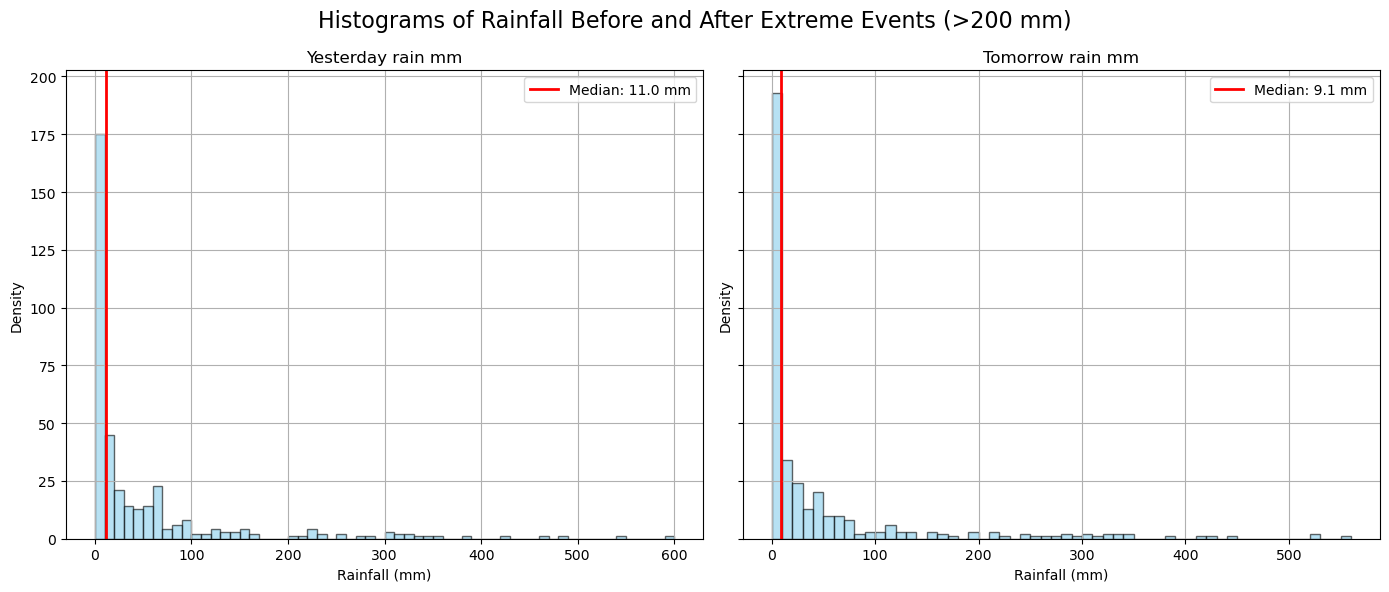

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def plot_histograms_yesterday_tomorrow(df):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for i, col in enumerate(['yesterday_rain_mm', 'tomorrow_rain_mm']):
        data = df[col].dropna()
        
        # Define bin edges based on bin size
        min_val = data.min()
        max_val = data.max()
        bin_step = 10
        bins = np.arange(min_val, max_val + bin_step, bin_step)
        # Histogram
        axes[i].hist(data, bins=bins, density=False, alpha=0.6, color='skyblue', edgecolor='black')
        
        # Median
        median_val = np.median(data)
        axes[i].axvline(median_val, color='red', linestyle='-', linewidth=2, label=f'Median: {median_val:.1f} mm')
        
        # Normal distribution curve
        mu, std = norm.fit(data)
        x = np.linspace(data.min(), data.max(), 100)
        p = norm.pdf(x, mu, std)
        # axes[i].plot(x, p, 'b--', linewidth=2, label=f'Normal fit\nμ={mu:.1f}, σ={std:.1f}')
        
        axes[i].set_title(f'{col.replace("_", " ").capitalize()}')
        axes[i].set_xlabel('Rainfall (mm)')
        axes[i].set_ylabel('Density')
        axes[i].legend()
        axes[i].grid(True)

    plt.suptitle(f'Histograms of Rainfall Before and After Extreme Events (>{threshold_rain_mm} mm)', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_histograms_yesterday_tomorrow(df_q5_peaks)

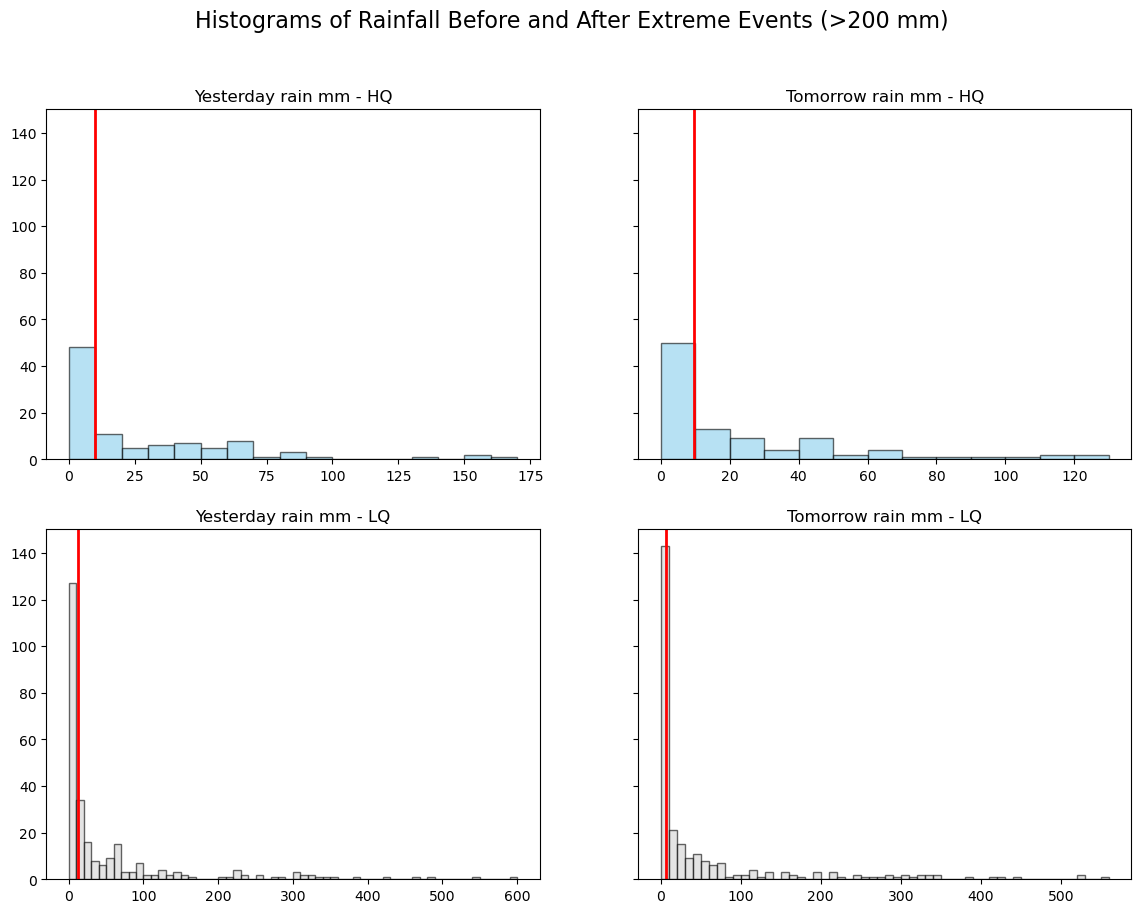

In [111]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def plot_histograms_yesterday_tomorrow(df):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

    categories = ['HQ', 'LQ']
    colors = {'HQ': 'skyblue', 'LQ': 'lightgray'}

    for row_idx, quality in enumerate(categories):
        if quality == 'LQ':
            df_quality = df[df['visual_quality'] == 'LQ']
        else:
            df_quality = df[df['visual_quality'] == 'HQ']

        for col_idx, rain_col in enumerate(['yesterday_rain_mm', 'tomorrow_rain_mm']):
            data = df_quality[rain_col].dropna()

            if data.empty:
                continue

            # Bin setup
            min_val = data.min()
            max_val = data.max()
            bin_step = 10
            bins = np.arange(min_val, max_val + bin_step, bin_step)

            ax = axes[row_idx, col_idx]

            # Histogram
            ax.hist(data, bins=bins, density=False, alpha=0.6,
                    color=colors[quality], edgecolor='black', label=f'{quality} ({len(data)})')

            # Median
            median_val = np.median(data)
            ax.axvline(median_val, color='red', linestyle='-', linewidth=2, label=f'Median: {median_val:.1f} mm')

            # Optional: Normal distribution curve (comment to disable)
            # mu, std = norm.fit(data)
            # x = np.linspace(data.min(), data.max(), 100)
            # p = norm.pdf(x, mu, std)
            # ax.plot(x, p * len(data) * bin_step, 'b--', linewidth=2, label=f'Normal fit\nμ={mu:.1f}, σ={std:.1f}')

            ax.set_title(f'{rain_col.replace("_", " ").capitalize()} - {quality}')
            plt.suptitle(f'Histograms of Rainfall Before and After Extreme Events (>{threshold_rain_mm} mm)', fontsize=16)


plot_histograms_yesterday_tomorrow(df_q5_peaks)

# Q6 - Neighbors

In [ ]:
# file_path = './1 - Organized data gauge/BRAZIL/DATASETS/BRAZIL_DAILY_1961_2024_CLEANED.h5'
# with h5py.File(file_path, 'r') as hdf:
#     keys = list(hdf.keys())
#     print(keys)

In [123]:
# df_qc_info = pd.read_hdf(file_path, key = 'table_qc_info', encoding = 'utf-8')
# df_qc_info = df_qc_info[df_qc_info['gauge_code'] == '00655001']
# df_qc_info.tail(10)

In [236]:
import os
brazil_folder_path = r".\1 - Organized data gauge\\"
brazil_h5_files = glob.glob(os.path.join(brazil_folder_path, "*.h5"))
cemaden_path = brazil_h5_files[0]
cemaden_path = r'.\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\BRASIL_CEMADEN_TOTAL_DAILY.h5'

In [237]:
with h5py.File(cemaden_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['table_data', 'table_p_availability', 'table_q1_gaps', 'table_q2_week', 'table_q3_outliers', 'table_q4_volume_dow', 'table_quality_index', 'table_quality_index_q4']


In [ ]:
cemaden_data = pd.read_hdf(r'.\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\BRASIL_CEMADEN_TOTAL_DAILY.h5', key = 'table_info')
cemaden_data = cemaden_data[cemaden_data['rain_mm']<= 600.0].sort_values(['datetime', 'gauge_code'])
cemaden_data = cemaden_data.rename(columns={'datetime': 'datetime'})
cemaden_data

,gauge_code,datetime,rain_mm,year
152042,230370901A,2014-01-01,0.00,2014
153498,230370902A,2014-01-01,0.00,2014
154746,230370903A,2014-01-01,0.00,2014
156806,230370904A,2014-01-01,0.00,2014
158207,230370905A,2014-01-01,0.00,2014
...,...,...,...,...
1054317,530010804A,2020-12-31,25.00,2020
1055880,530010805A,2020-12-31,0.00,2020
6130370,CEMADEN_10,2020-12-31,0.79,2020
6130394,CEMADEN_11,2020-12-31,1.38,2020


In [ ]:
cemaden_info = pd.read_hdf(r'.\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\BRASIL_CEMADEN_TOTAL_DAILY.h5', key = 'table_info')
cemaden_info = cemaden_info[['gauge_code', 'lat', 'long']]
cemaden_info

,gauge_code,lat,long
18981,S717,-20.351389,-51.430278
18980,S716,-21.305889,-52.820375
18979,S715,-20.466694,-53.763028
18978,S714,-18.072778,-54.548889
18977,S713,-22.078611,-53.465833
...,...,...,...
4,00047005,-0.633600,-47.658300
3,00047004,-0.929400,-47.099400
2,00047003,-0.737500,-47.853600
1,00047002,-0.623100,-47.353600


In [233]:
cemaden_total = pd.merge(cemaden_data, cemaden_info, on = 'gauge_code', how='left')
cemaden_total.sort_values('lat', inplace=True)
cemaden_total.tail(20)

,gauge_code,datetime,rain_mm,year,lat,long
6072608,355030874A,2020-12-12,0.0,2020,NaN,NaN
6074201,292400901C,2020-12-13,0.0,2020,NaN,NaN
6075627,355030874A,2020-12-13,0.0,2020,NaN,NaN
6077227,292400901C,2020-12-14,0.0,2020,NaN,NaN
6078647,355030874A,2020-12-14,0.0,2020,NaN,NaN
6080236,292400901C,2020-12-15,0.0,2020,NaN,NaN
6081650,355030874A,2020-12-15,0.0,2020,NaN,NaN
6082469,130350201A,2020-12-16,0.0,2020,NaN,NaN
6083249,292400901C,2020-12-16,0.0,2020,NaN,NaN
6085755,230500101C,2020-12-17,4.2,2020,NaN,NaN


In [ ]:
# Ensure datetime is in datetime format
cemaden_total['datetime'] = pd.to_datetime(cemaden_total['datetime']).dt.date

# Haversine function to compute distance between two lat/long points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Prepare new columns
nearest_codes = []
nearest_rains = []
rain_avg = []
rain_std = []
distances_km = []
distance_avg = []

cemaden_total_200mm = cemaden_total[
    (cemaden_total['rain_mm'] >= 200.0)
    & (cemaden_total['rain_mm'] <= 600.0)
    ]

# Iterate through rows with progress bar
for idx, row in tqdm(cemaden_total_200mm.iterrows(), total=len(cemaden_total_200mm)):
    # print(idx, row, row['rain_mm'])
    row_date = row['datetime']
    row_lat = row['lat']
    row_lon = row['long']
    row_code = row['gauge_code']
    row_rain_mm = row['rain_mm']
    
    if row_rain_mm >= 200.0:
        # print('\n\nok\n\n')
        # Subset for same date excluding itself and non-NaN rain_mm
        same_day = cemaden_total[
            (cemaden_total['datetime'] == row_date) &
            (cemaden_total['gauge_code'] != row_code) &
            (cemaden_total['rain_mm'].notna())
        ].copy()
        
        # Calculate distances
        same_day['distance_km'] = same_day.apply(
            lambda r: haversine(row_lat, row_lon, r['lat'], r['long']), axis=1
        )
        
        # Take 5 nearest
        nearest_5 = same_day.nsmallest(5, 'distance_km')
        
        # Collect info
        nearest_codes.append(nearest_5['gauge_code'].tolist())
        nearest_rains.append(nearest_5['rain_mm'].tolist())
        rain_avg.append(np.mean(nearest_5['rain_mm']))
        rain_std.append(np.std(nearest_5['rain_mm']))
        distances_km.append(nearest_5['distance_km'].tolist())
        distance_avg.append(np.mean(nearest_5['distance_km']))
    else:
        nearest_codes.append([])
        nearest_rains.append([])
        rain_avg.append(np.nan)
        rain_std.append(np.nan)
        distances_km.append([])
        distance_avg.append(np.nan)

# Add new columns
cemaden_total_200mm['nearest_codes'] = nearest_codes
cemaden_total_200mm['nearest_rains'] = nearest_rains
cemaden_total_200mm['nearest_rain_avg'] = rain_avg
cemaden_total_200mm['nearest_rain_std'] = rain_std
cemaden_total_200mm['nearest_distances_km'] = distances_km
cemaden_total_200mm['nearest_distance_avg_km'] = distance_avg

100%|██████████| 372/372 [03:17<00:00,  1.89it/s]
C:\Users\linde\AppData\Local\Temp\ipykernel_32088\3806550462.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cemaden_total_200mm['nearest_codes'] = nearest_codes
C:\Users\linde\AppData\Local\Temp\ipykernel_32088\3806550462.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cemaden_total_200mm['nearest_rains'] = nearest_rains
C:\Users\linde\AppData\Local\Temp\ipykernel_32088\3806550462.py:70: SettingWithCopyWarning: 
A value is trying to be set on a co

In [227]:
# cemaden_total_200mm = cemaden_total_200mm[cemaden_total_200mm['rain_mm'] <= 600]
cemaden_total_200mm['year'] = cemaden_total_200mm['datetime'].dt.year
cemaden_total_200mm_hq_lq = pd.merge(cemaden_total_200mm, df_cemaden_hq, on = ['gauge_code', 'year'], how = 'left')
cemaden_total_200mm_hq_lq['visual_quality'] = np.where(cemaden_total_200mm_hq_lq['visual_quality'] == 'HQ', 'HQ', 'LQ')
cemaden_total_200mm_hq_lq.to_excel(r'.\5 - Results\cemaden_total_200mm.xlsx', index=False, sheet_name='data')
cemaden_total_200mm_hq_lq

C:\Users\linde\AppData\Local\Temp\ipykernel_32088\2034510090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cemaden_total_200mm['year'] = cemaden_total_200mm['datetime'].dt.year


,gauge_code,datetime,rain_mm,year,lat,long,date,nearest_codes,nearest_rains,nearest_rain_avg,nearest_rain_std,nearest_distances_km,nearest_distance_avg_km,visual_quality
0,351870116A,2014-02-01,245.369766,2014,-23.90700,-46.16400,2014-02-01,"[354850009A, 351870115A, 351870112A, 350635902...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,"[3.10235989162117, 4.067469901070567, 5.119653...",5.369946,LQ
1,230440013A,2014-02-09,384.763400,2014,NaN,NaN,2014-02-09,"[110020501A, 110020502A, 120040101A, 120040102...","[0.5926800000000001, 4.9221820670000005, 0.600...",5.075100,7.309284,"[nan, nan, nan, nan, nan]",NaN,LQ
2,352990601A,2014-02-15,274.084072,2014,-24.28939,-47.45806,2014-02-15,"[353720602A, 353720601A, 354260202A, 354260203...","[148.107178809, 161.079852563, 62.447632263, 1...",91.498604,54.234920,"[22.159887975214666, 22.968706815628444, 44.82...",36.485220,HQ
3,355540607A,2014-02-15,211.519555,2014,-23.51700,-45.19600,2014-02-15,"[355540602A, 355540619A, 355540605A, 351050005...","[170.949770615, 138.589329805, 114.643101609, ...",126.393301,62.145790,"[3.4700147616137396, 4.959215228022006, 5.2987...",7.642319,HQ
4,355540613A,2014-02-15,203.908136,2014,-23.41900,-45.06600,2014-02-15,"[355540616A, 355540622A, 355540617A, 355540611...","[178.567058614, 190.556706932, 193.40696474199...",161.972525,31.673905,"[2.01036701954887, 2.8491210612933826, 4.38137...",4.350283,LQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,311320603A,2020-12-13,429.870000,2020,-20.95300,-43.80700,2020-12-13,"[311320601A, 311320605A, 311320604A, 311320607...","[4.2, 0.4, 0.2, 0.79, 0.6000000000000001]",1.238000,1.494047,"[0.2076841203726939, 1.8303208457267628, 2.494...",2.596304,LQ
368,311320603A,2020-12-17,247.430000,2020,-20.95300,-43.80700,2020-12-17,"[311320601A, 311320605A, 311320604A, 311320607...","[32.25, 0.8, 42.03, 46.66, 44.44]",33.236000,16.947768,"[0.2076841203726939, 1.8303208457267628, 2.494...",2.596304,LQ
369,330250202A,2020-12-22,256.080000,2020,-22.57600,-43.18800,2020-12-22,"[330250203A, 330250201A, 330250204A, 330390610...","[251.56, 16.76, 228.87, 43.63, 5.72]",109.308000,107.833120,"[2.066289490080446, 2.517614537138197, 2.89835...",2.987709,LQ
370,330250203A,2020-12-22,251.560000,2020,-22.59400,-43.18300,2020-12-22,"[330250204A, 330250201A, 330250202A, 330390610...","[228.87, 16.76, 256.08, 43.63, 5.72]",110.212000,109.034134,"[1.1435507673804306, 1.958910728192568, 2.0662...",3.312380,LQ


In [228]:
cemaden_total_200mm_hq_lq['rain_mm_percent'] = cemaden_total_200mm_hq_lq['nearest_rain_avg']/cemaden_total_200mm_hq_lq['rain_mm'] * 100
cemaden_total_200mm_hq_lq.sort_values(['rain_mm_percent'], inplace=True)
cemaden_total_200mm_hq_lq

,gauge_code,datetime,rain_mm,year,lat,long,date,nearest_codes,nearest_rains,nearest_rain_avg,nearest_rain_std,nearest_distances_km,nearest_distance_avg_km,visual_quality,rain_mm_percent
0,351870116A,2014-02-01,245.369766,2014,-23.907000,-46.164000,2014-02-01,"[354850009A, 351870115A, 351870112A, 350635902...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,"[3.10235989162117, 4.067469901070567, 5.119653...",5.369946,LQ,0.000000
288,420730402A,2019-08-26,366.400000,2019,-28.238140,-48.660140,2019-08-26,"[420730401A, 420570402A, 420570403A, 420940903...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,"[9.965381688524623, 15.198921276210923, 20.632...",20.929471,LQ,0.000000
69,330580205A,2016-01-07,259.500000,2016,-22.400000,-42.955000,2016-01-07,"[330580221A, 330580204A, 330580208A, 330580217...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,"[1.5994845387974501, 3.1955263780045624, 3.339...",4.167809,LQ,0.000000
175,230440009A,2018-03-15,440.020000,2018,-3.753000,-38.567000,2018-03-15,"[230440016A, 230440004A, 230440011A, 230440005...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,"[2.2826695141959115, 2.7887168335889716, 3.087...",2.953270,LQ,0.000000
162,310620013A,2018-01-20,515.060000,2018,-19.866092,-43.938110,2018-01-20,"[310620007A, 315670001A, 315670002A, 310620018...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,"[1.8709226677949073, 3.9617087520149097, 7.762...",6.544623,LQ,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,261070705A,2016-05-30,210.990000,2016,-7.941571,-34.825915,2016-05-30,"[261070704A, 260960005A, 261070702A, 260960004...","[221.24, 232.97, 215.79999999999998, 241.87, 2...",224.946000,10.904158,"[2.6429051153102154, 5.8045313158753835, 5.810...",5.910422,HQ,106.614531
19,320500205A,2014-10-30,215.955973,2014,-20.219000,-40.281000,2014-10-30,"[320500201A, 320500210A, 320500211A, 320500209...","[172.21673855400002, 182.438424811, 255.760850...",249.051106,70.372761,"[1.4659963464441463, 2.0445675043019462, 2.748...",2.786203,LQ,115.324945
34,355070416A,2014-12-23,265.465872,2014,-23.793000,-45.566000,2014-12-23,"[355070419A, 355070413A, 355070414A, 355070406...","[344.669654523, 317.18257998900003, 335.389328...",306.678412,42.406870,"[4.204385855527665, 4.2581340776486805, 5.0072...",6.989086,LQ,115.524610
30,355070410A,2014-12-23,225.452977,2014,-23.768000,-45.685000,2014-12-23,"[355070406A, 355070411A, 355070414A, 355070402...","[310.697519681, 205.322075581, 335.389328187, ...",269.774007,76.718226,"[3.3756629563893257, 3.896114758573602, 7.4956...",6.388258,LQ,119.658658


In [230]:
cemaden_total_200mm_hq_lq_deletion = cemaden_total_200mm_hq_lq[cemaden_total_200mm_hq_lq['rain_mm_percent']<35.0]
cemaden_total_200mm_hq_lq_deletion = cemaden_total_200mm_hq_lq_deletion[['gauge_code', 'datetime']]
cemaden_total_200mm_hq_lq_deletion


,gauge_code,datetime
0,351870116A,2014-02-01
288,420730402A,2019-08-26
69,330580205A,2016-01-07
175,230440009A,2018-03-15
162,310620013A,2018-01-20
...,...,...
84,330270003A,2016-02-29
66,355540623A,2016-01-02
2,352990601A,2014-02-15
10,355070402A,2014-04-14


# Quality Index

In [60]:
df_p_availability = pd.read_hdf(cemaden_daily_data_path, key = 'table_p_availability', encoding = 'utf-8')
df_q1_gaps = pd.read_hdf(cemaden_daily_data_path, key = 'table_q1_gaps', encoding = 'utf-8')
df_q2_week = pd.read_hdf(cemaden_daily_data_path, key = 'table_q2_week', encoding = 'utf-8')
df_q3_outliers = pd.read_hdf(cemaden_daily_data_path, key = 'table_q3_outliers', encoding = 'utf-8')
df_q4_volume_dow = pd.read_hdf(cemaden_daily_data_path, key = 'table_q4_volume_dow', encoding = 'utf-8')

In [61]:
df_q_index = pd.merge(df_preclassif[['gauge_code', 'year', 'preclassif']]
                      , df_p_availability
                      , on = ['gauge_code', 'year']
                      , how='left').merge(df_q1_gaps
                                          , on = ['gauge_code', 'year']
                                          , how='left').merge(df_q2_week
                                                              , on = ['gauge_code', 'year']
                                                              , how='left').merge(df_q3_outliers
                                                              , on = ['gauge_code', 'year']
                                                              , how='left').merge(df_q4_volume_dow
                                                              , on = ['gauge_code', 'year']
                                                              , how='left')
df_q_index.fillna(0, inplace=True)
df_q_index

,gauge_code,year,preclassif,p_availability,q1_gaps,q2_week,q3_outliers,q4_volume_dow
0,110018901A,2018,LQ,37.260274,0.000000,79.213015,94.852941,70.294867
1,110018901A,2019,,94.794521,87.123288,91.236742,97.687861,84.950291
2,110018901A,2020,LQ,10.382514,0.000000,67.725139,100.000000,67.459019
3,110020501A,2014,LQ,4.383562,0.000000,65.984933,100.000000,39.818243
4,110020501A,2017,LQ,1.643836,0.000000,0.000000,100.000000,40.135403
...,...,...,...,...,...,...,...,...
22768,CEMADEN_12,2019,LQ,24.657534,0.000000,90.159144,95.555556,81.088026
22769,CEMADEN_12,2020,LQ,8.469945,0.000000,88.614499,93.548387,60.956171
22770,CEMADEN_13,2019,LQ,6.301370,0.000000,20.627461,95.652174,21.808237
22771,CEMADEN_14,2018,LQ,25.205479,0.000000,78.723842,93.478261,77.933668


In [62]:
df_q_index['quality_index'] = df_q_index[['p_availability', 'q1_gaps', 'q2_week', 'q3_outliers', 'q4_volume_dow']].mean(axis=1)

df_q_index['quality_label'] = df_q_index.apply(calculate_quality_label, axis=1)

df_q_index['final_classif'] = df_q_index.apply(
    lambda row: 'LQ' if row['quality_label'] in ['4 - Low Quality', '5 - Very Low Quality'] or row['preclassif'] == 'LQ' else 'HQ',
    axis=1
)

df_q_index

,gauge_code,year,preclassif,p_availability,q1_gaps,q2_week,q3_outliers,q4_volume_dow,quality_index,quality_label,final_classif
0,110018901A,2018,LQ,37.260274,0.000000,79.213015,94.852941,70.294867,56.324219,4 - Low Quality,LQ
1,110018901A,2019,,94.794521,87.123288,91.236742,97.687861,84.950291,91.158540,3 - Acceptable Quality,HQ
2,110018901A,2020,LQ,10.382514,0.000000,67.725139,100.000000,67.459019,49.113334,5 - Very Low Quality,LQ
3,110020501A,2014,LQ,4.383562,0.000000,65.984933,100.000000,39.818243,42.037348,5 - Very Low Quality,LQ
4,110020501A,2017,LQ,1.643836,0.000000,0.000000,100.000000,40.135403,28.355848,5 - Very Low Quality,LQ
...,...,...,...,...,...,...,...,...,...,...,...
22768,CEMADEN_12,2019,LQ,24.657534,0.000000,90.159144,95.555556,81.088026,58.292052,4 - Low Quality,LQ
22769,CEMADEN_12,2020,LQ,8.469945,0.000000,88.614499,93.548387,60.956171,50.317801,4 - Low Quality,LQ
22770,CEMADEN_13,2019,LQ,6.301370,0.000000,20.627461,95.652174,21.808237,28.877848,5 - Very Low Quality,LQ
22771,CEMADEN_14,2018,LQ,25.205479,0.000000,78.723842,93.478261,77.933668,55.068250,4 - Low Quality,LQ


In [63]:
df_q_index.to_hdf(cemaden_daily_data_path, key = 'table_quality_index_q5', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_q_index

,gauge_code,year,preclassif,p_availability,q1_gaps,q2_week,q3_outliers,q4_volume_dow,quality_index,quality_label,final_classif
0,110018901A,2018,LQ,37.260274,0.000000,79.213015,94.852941,70.294867,56.324219,4 - Low Quality,LQ
1,110018901A,2019,,94.794521,87.123288,91.236742,97.687861,84.950291,91.158540,3 - Acceptable Quality,HQ
2,110018901A,2020,LQ,10.382514,0.000000,67.725139,100.000000,67.459019,49.113334,5 - Very Low Quality,LQ
3,110020501A,2014,LQ,4.383562,0.000000,65.984933,100.000000,39.818243,42.037348,5 - Very Low Quality,LQ
4,110020501A,2017,LQ,1.643836,0.000000,0.000000,100.000000,40.135403,28.355848,5 - Very Low Quality,LQ
...,...,...,...,...,...,...,...,...,...,...,...
22768,CEMADEN_12,2019,LQ,24.657534,0.000000,90.159144,95.555556,81.088026,58.292052,4 - Low Quality,LQ
22769,CEMADEN_12,2020,LQ,8.469945,0.000000,88.614499,93.548387,60.956171,50.317801,4 - Low Quality,LQ
22770,CEMADEN_13,2019,LQ,6.301370,0.000000,20.627461,95.652174,21.808237,28.877848,5 - Very Low Quality,LQ
22771,CEMADEN_14,2018,LQ,25.205479,0.000000,78.723842,93.478261,77.933668,55.068250,4 - Low Quality,LQ


# Visual Analysis

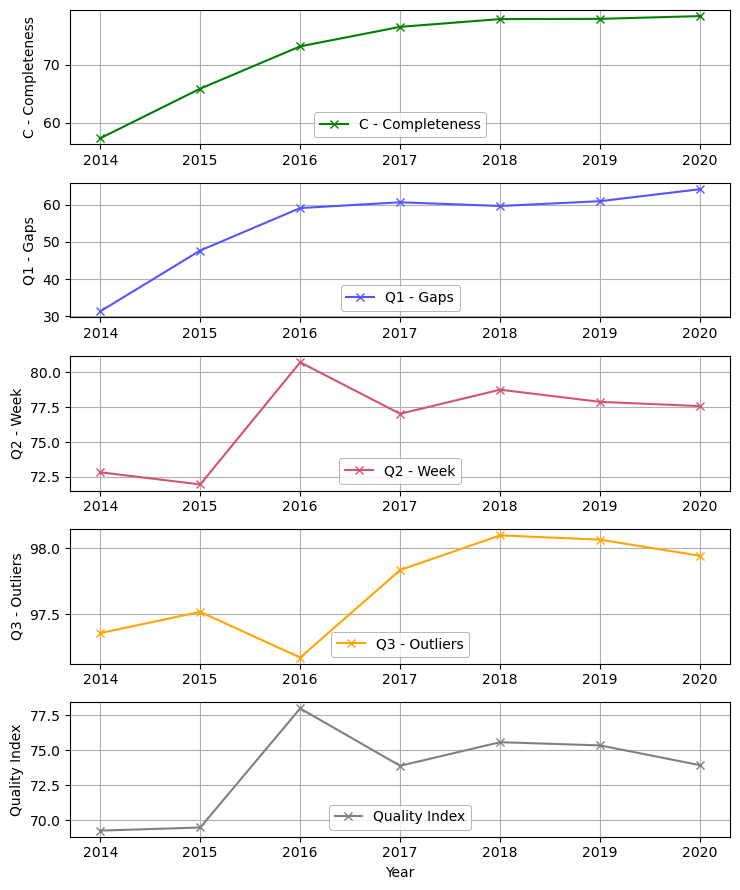

In [ ]:
# Calculate the average value of each parameter by year
df_avg_params = df_q_index.groupby('year').agg({
    'p_availability': 'mean',
    'q1_gaps': 'mean',
    'q2_week': 'mean',
    'q3_outliers': 'mean',
    'q4_volume_dow': 'mean'
}).reset_index()

# Create a figure and axis with a custom size
fig, ax = plt.subplots(6, 1, figsize=(7.5, 9), sharex=True)

# Plot each parameter
ax0 = ax[0]
ax0.plot(df_avg_params['year'], df_avg_params['p_availability'], marker='x', color='g', label='C - Completeness')
ax0.set_ylabel('C - Completeness')
ax0.grid(True)
lines, labels = ax0.get_legend_handles_labels()
legend = ax0.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)


ax1 = ax[1]
ax1.plot(df_avg_params['year'], df_avg_params['q1_gaps'], marker='x', color='#5555ff', label='Q1 - Gaps')
ax1.set_ylabel('Q1 - Gaps')
ax1.grid(True)
lines, labels = ax1.get_legend_handles_labels()
legend = ax1.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)


ax2 = ax[2]
ax2.plot(df_avg_params['year'], df_avg_params['q2_week'], marker='x', color='#d3546e', label='Q2 - Week')
ax2.set_ylabel('Q2 - Week')
ax2.grid(True)
lines, labels = ax2.get_legend_handles_labels()
legend = ax2.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)


ax3 = ax[3]
ax3.ylim = (97, None)
ax3.plot(df_avg_params['year'], df_avg_params['q3_outliers'], marker='x', color='Orange', label='Q3 - Outliers')
ax3.set_ylabel('Q3 - Outliers')
ax3.grid(True)
lines, labels = ax3.get_legend_handles_labels()
legend = ax3.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

ax4 = ax[4]
ax4.plot(df_avg_params['year'], df_avg_params['q4_volume_dow'], marker='x', color='grey', label='Q4 - Volume DOW')
ax4.set_xlabel('Year')
ax4.set_ylabel('Q4 - Volume DOW')
ax4.grid(True)
lines, labels = ax4.get_legend_handles_labels()

legend = ax4.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

ax4 = ax[5]
ax4.plot(df_avg_params['year'], df_avg_params['quality_index'], marker='x', color='grey', label='Quality Index')
ax4.set_xlabel('Year')
ax4.set_ylabel('Quality Index')
ax4.grid(True)
lines, labels = ax4.get_legend_handles_labels()

legend = ax4.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)



# Show xticks on all subplots
for a in ax:
    a.label_outer()  # Hides labels except for the last subplot but keeps ticks visible
    a.tick_params(axis='x', which='both', labelbottom=True)  # Ensure xticks are visible
    
plt.tight_layout()
# plt.savefig('./figures/quality_index_avg_year_cemaden.tiff', dpi = 300, bbox_inches='tight')
plt.show()
plt.close()

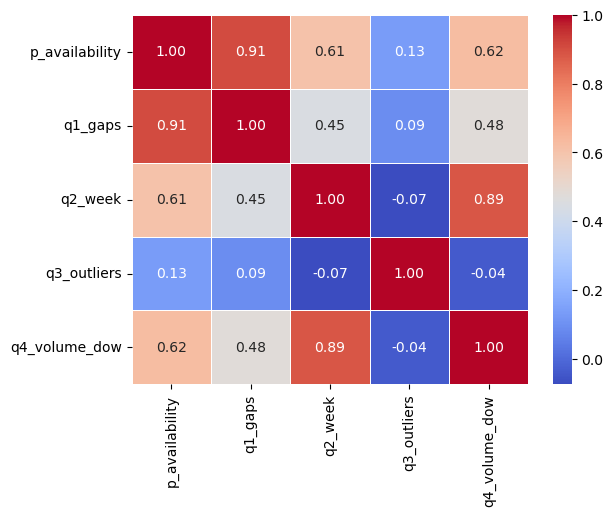

In [65]:
# Select relevant columns for the heatmap
heatmap_data = df_q_index[['p_availability', 'q1_gaps', 'q2_week', 'q3_outliers', 'q4_volume_dow']]

# Calculate the correlation matrix
corr = heatmap_data.corr()

# Create a heatmap
# plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Heatmap of df_qc_info Parameters')
plt.show()

In [66]:
df_qc_count = df_q_index.groupby('quality_label').size().reset_index(name='count')
df_qc_count['percent'] = (df_qc_count['count'] / df_qc_count['count'].sum()) * 100
df_qc_count

# quality_label	count	percent
# 1 - Excellent Quality	    6626	29.095859
# 2 - Good Quality	        3474	15.254907
# 3 - Acceptable Quality	1887	8.286128
# 4 - Low Quality	        7245	31.813990
# 5 - Very Low Quality	    3541	15.549115

,quality_label,count,percent
0,1 - Excellent Quality,6212,27.277917
1,2 - Good Quality,3752,16.475651
2,3 - Acceptable Quality,1923,8.444210
3,4 - Low Quality,8108,35.603566
4,5 - Very Low Quality,2778,12.198656


In [67]:
df_qc_avg = df_q_index.groupby('quality_label').agg({'p_availability': 'mean'
                                                     , 'q1_gaps':'mean'
                                                     , 'q2_week':'mean'
                                                     , 'q3_outliers':'mean'
                                                     , 'q4_volume_dow': 'mean'
                                                     }).reset_index()
df_qc_avg

,quality_label,p_availability,q1_gaps,q2_week,q3_outliers,q4_volume_dow
0,1 - Excellent Quality,99.938036,99.822082,87.072730,97.801458,83.971999
1,2 - Good Quality,97.688985,93.785336,85.002994,98.050033,82.188149
2,3 - Acceptable Quality,92.822382,80.093610,83.820217,98.036409,80.628569
3,4 - Low Quality,58.789418,19.953861,79.112927,97.656623,75.114222
4,5 - Very Low Quality,12.870421,0.459710,32.791932,97.312726,32.833008


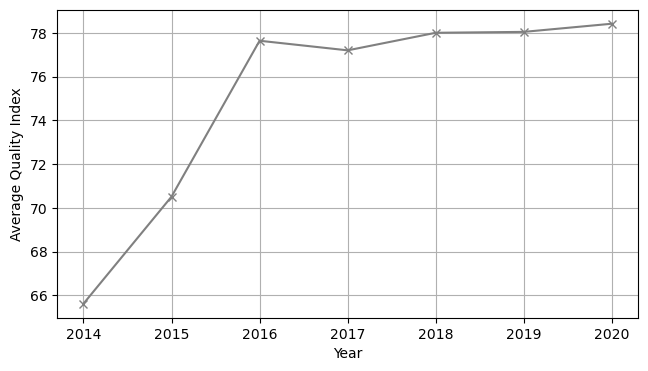

In [68]:
# Calculate the average quality index over the years
df_avg_quality_index = df_q_index.groupby('year')['quality_index'].mean().reset_index()

# Create a figure and axis with a custom size
fig, ax = plt.subplots(figsize=(7.5, 4))

# Plot the average quality index over the years
ax.plot(df_avg_quality_index['year'], df_avg_quality_index['quality_index'], marker='x', color='grey', label='Average Quality Index')

# Add labels, title, and grid
ax.set_xlabel('Year')
ax.set_ylabel('Average Quality Index')
# ax.set_title('Average Quality Index Over the Years')
ax.grid(True)

# plt.savefig('./figures/quality_index_over_the_years_cemaden.png', dpi=1800, bbox_inches='tight')
plt.show()
plt.close()

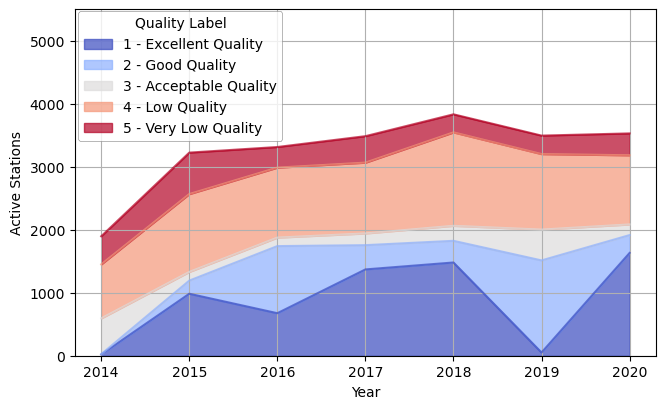

In [69]:

# Group by year and quality label to get the count of active stations
df_active_stations = df_q_index.groupby(['year', 'quality_label']).size().unstack(fill_value=0)

# Create a stacked area plot with updated figure size
fig, ax = plt.subplots(figsize=(7.5, 4.5))

# Use a colorblind-friendly colormap
df_active_stations.plot(kind='area', stacked=True, ax=ax, colormap='coolwarm', alpha=0.7)

# Add labels, title, and grid
ax.set_xlabel('Year')
ax.set_ylabel('Active Stations')
# ax.set_title('Count of Active Stations by Year and Quality Label')
ax.grid(True)
ax.set_ylim(0, 5500)
# Modify the EXISTING legend from pandas plot
legend = ax.legend()
legend.set_title('Quality Label')  # Set title
legend.set_bbox_to_anchor((0.369, 0.6))  # Set legend position
legend.set_frame_on(True)  # Ensure frame is visible

# Customize frame properties
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

# plt.savefig('./figures/active_stations_by_year_and_quality_label_cemaden.tiff', dpi=300, bbox_inches='tight')

plt.show()
plt.close()